# ChainerでVAEを書いてみる
* 以下のページを参考に
  * https://github.com/RyotaKatoh/chainer-Variational-AutoEncoder
* VAEについては以下を参照した
  * http://papers.nips.cc/paper/5352-semi-supervised-learning-with-deep-generative-models.pdf
  * http://deeplearning.jp/wp-content/uploads/2014/04/dl_hacks2015-04-21-iwasawa1.pdf


In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import six

import matplotlib.pyplot as plt

In [2]:
# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data

## GPU設定

In [3]:
gpu_flag = -1
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## MNISTデータのダウンロードといくつかプロットして確認

In [12]:
mnist = data.load_mnist_data()
# 70,000の手書き数字データ

In [25]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2, 2))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

# いくつかプロット
def draw_digit_multi(data, n=10):
    # サンプラー
    indexes = np.random.permutation( len(data) )[:n]
    # 
    size = 28
    plt.figure(figsize=(15, 2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

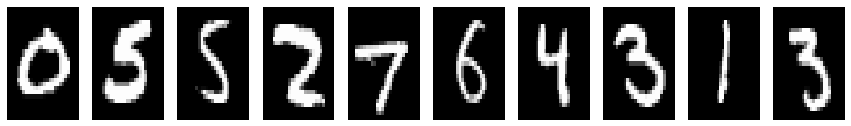

labels : 
[0 5 5 2 7 6 4 3 1 3]


In [34]:
idxs = draw_digit_multi(mnist['data'])
print "labels : "
print mnist['target'][idxs]